In [15]:
from pyfishsensedev.image import ImageRectifier, RawProcessor
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from pyfishsensedev.calibration import LensCalibration, LaserCalibration
from pyfishsensedev.image.image_processors.raw_processor_old import RawProcessorOld
from pyfishsensedev.laser.nn_laser_detector import NNLaserDetector
import torch

In [16]:
ORF_FILE = Path("/mnt/fishsense_data/REEF/data/2023.08.03.FishSense.FSL-01D/H slate dive 1/P8030006.ORF")
LENS_CALIBRATION_FILE = Path("./data/lens-calibration.pkg")
LASER_CALIBRATION_FILE = Path("./data/laser-calibration.pkg")

In [17]:
lens_calibration = LensCalibration()
lens_calibration.load(LENS_CALIBRATION_FILE)

laser_calibration = LaserCalibration()
laser_calibration.load(LASER_CALIBRATION_FILE)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
def uint8_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 255

def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def double_2_uint8(img: np.ndarray) -> np.ndarray:
    return (img * 255).astype(np.uint8)

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return double_2_uint8(uint16_2_double(img))

def imshow(img: np.ndarray | Image.Image):
    if hasattr(img, "dtype"):
        arr = img
    elif isinstance(img, Image.Image):
        arr = np.array(img)

    if arr.dtype == np.uint16:
        arr = uint16_2_uint8(img)
    elif arr.dtype == float:
        arr = double_2_uint8(arr / arr.max())

    plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In [20]:
raw_process = RawProcessor(ORF_FILE)
dark_raw_processor = RawProcessorOld(Path(ORF_FILE), enable_histogram_equalization=False)

image_rectifier = ImageRectifier(lens_calibration)

img = next(raw_process.__iter__())
img = image_rectifier.rectify(img)

img_dark = next(dark_raw_processor.__iter__())
img_dark = image_rectifier.rectify(img_dark)

img8 = uint16_2_uint8(img)
img_dark8 = uint16_2_uint8(img_dark)

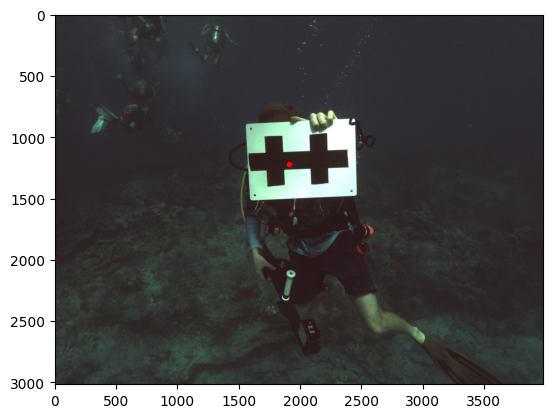

In [21]:
laser_detector = NNLaserDetector(lens_calibration, laser_calibration, device)
laser_coords = laser_detector.find_laser(img_dark8)
laser_coords_int = np.round(laser_coords).astype(int)

imshow(img_dark8)
plt.plot(laser_coords[0], laser_coords[1], 'r.')
plt.show()